# DFT MD on disordered `HfNbTaZr` alloy

A disordered equiatomic `HfNbTaZr` crystal was generated in Vesta using atomic positions seeded randomly using `mcsqs`.

This notebook handles a few things:
1. Slab relaxation, if `RUN_RELAXATION=True`
2. MD run at configurable # time steps, dt, initial eV
3. Previewing system (`preview(...)`)

Use `ase gui <output_filename.out>` to view animated relax/MD output.

# Helpers

In [492]:
from ase import Atom, Atoms
from ase.calculators.espresso import Espresso
from ase.constraints import FixAtoms
from ase.io.cif import read_cif
from ase.io.espresso import read_espresso_out, write_espresso_in
from ase.io.vasp import read_vasp
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from copy import deepcopy
from enum import Enum
from matplotlib import pyplot as plt
import math
import numpy as npm
import os
import re
import shutil

In [493]:
# File/directory constants
PSEUDO_DIR = 'q-e/pseudo/'
PSEUDOPOTENTIALS = {
    'Ta': 'ta_pbe_v1.uspp.F.UPF',
    'Nb': 'nb_pbe_v1.uspp.F.UPF',
    'Hf': 'hf_pbe_v1.uspp.F.UPF',
    'Zr': 'zr_pbe_v1.uspp.F.UPF',
    'H': 'h_pbe_v1.4.uspp.F.UPF'
}
OUTDIR = 'outdir'

In [494]:
# Numeric constants
# 1 picosecond = n Rydberg a.u.
PS_TO_AU = 1e-12 / (4.8378 * 1e-17)

# 1 femtosecond
FS_TO_AU = 1e-15 / (4.8378 * 1e-17)

In [518]:
class Calculation(Enum):
    RELAX = 'relax'
    VC_RELAX = 'vc-relax'
    MD = 'md'

class FileType(Enum):
    INPUT = 'in'
    OUTPUT = 'out'

In [496]:
def get_qe_filename(atoms, calc, filetype, suffix=''):
    """
    Returns a filename for a QE input/output file given an ase.Atoms object
    e.g. relax_Hf16Ta12Nb20Zr13H.in
    """
    assert isinstance(calc, Calculation)
    assert isinstance(filetype, FileType)
    _suffix = '_' + suffix if suffix else ''
    return f'{calc.value}_{atoms.symbols}{_suffix}.{filetype.value}'

In [497]:
def output_to_atoms(output_filename):
    """
    Reads QE atomic positions output into an ase.Atoms object
    """
    with open(output_filename, 'r') as f:
        generator = read_espresso_out(f, index=slice(None))
        atoms = [g for g in generator]
        atoms = atoms[-1]
    return atoms

In [498]:
def run(input_filename, output_filename):
    """
    Runs a QE operation. Assumes input file already exists
    """
    os.environ['INPUT_FILENAME'] = input_filename
    os.environ['OUTPUT_FILENAME'] = output_filename
    !mpirun -np 12 q-e/bin/pw.x -inp $INPUT_FILENAME > $OUTPUT_FILENAME

In [499]:
def velocity(atomic_mass, energy):
    """
    Computes the velocity of an atom in Hartree atomic units, given the atomic mass in atomic units and the energy in electronvolts.

    Args:
    atomic_mass: The atomic mass of the atom in atomic units.
    energy: The energy of the atom in electronvolts.

    Returns:
    The velocity of the atom in Hartree atomic units.
    """

    # Convert the atomic mass to kilograms.
    atomic_mass_kg = atomic_mass * 1.660539040e-27

    # Convert the energy to joules.
    energy_joules = energy * 1.60217662e-19

    # Calculate the velocity.
    velocity_ms = math.sqrt((2 * energy_joules) / atomic_mass_kg)

    # Convert the velocity to Hartree atomic units.
    velocity_ha = velocity_ms / 2.187691e6

    return velocity_ha

H_ATOMIC_MASS = 1.00784
assert math.isclose(velocity(H_ATOMIC_MASS, 40), 0.0400031, abs_tol=1e-6)

In [500]:
def preview(atoms):
    """
    Previews an ase.Atoms object.
    
        y
        |
        |_____ x
       / 
      /
     z

    """
    RADIUS = 0.1
    fig, (ax1, ax2) = plt.subplots(figsize=(9, 3), nrows=1, ncols=2)
    plot_atoms(atoms, ax1, radii=RADIUS, rotation=('0x,0y,0z'))
    plot_atoms(atoms, ax2, radii=RADIUS, rotation=('0x,90y,0z'))

In [491]:
def sanitize(filename):
    """
    Hack around a bug in ase.io: 
    
        File ~/git/md/venv/lib/python3.11/site-packages/ase/io/espresso.py:264, in <listcomp>(.0)
        261 for magmoms_index in indexes[_PW_MAGMOM]:
        262     if image_index < magmoms_index < next_index:
        263         magmoms = [
    --> 264             float(mag_line.split()[5]) for mag_line
        265             in pwo_lines[magmoms_index + 1:
        266                          magmoms_index + 1 + len(structure)]]
        268 # Fermi level / highest occupied level
        269 efermi = None

    ValueError: could not convert string to float: 'magn='
    """
    # Copy and rename the old file
    backup_filename = f'{filename}.old'
    shutil.copyfile(filename, backup_filename)
    print(f'Preserving existing job output in {backup_filename}') 
    with open(filename, 'r') as f:
        content = f.read()
    
    content = re.sub('magn=', '', content)
    with open(filename, 'w') as f:
        f.write(content)

## Read crystal generated by `mcsqs`/Vesta

In [503]:
def import_vasp(filename: str, truncate=False):
    """
    Helper to import a VASP/POSCAR file into an ase.Atoms object
    
    Args:
        filename: .vasp/.poscar(?) filename
        truncate: If True, truncate the input atomic positions into a smaller slab (for faster calculations later)
    """
    with open(filename, 'r') as f:
        generator = read_vasp(f)
        atoms = [a for a in generator]
    
    if truncate:
        Y_MAX, X_MAX = 5.0, 8.0
        atoms = [a for a in atoms if a.position[2] < X_MAX] # Fixed threshold
        atoms = [a for a in atoms if a.position[1] < Y_MAX]
    slab = Atoms(atoms)
    slab.set_positions(slab.positions + np.min(slab.positions) + 0.2)

    # Leave some room in the simulation box to avoid this error:
    # https://www.researchgate.net/post/what_should_I_do_with_this_error_in_quantum_espressoError_in_routine_check_atoms_1_atoms_1_and_2_differ_by_lattice_vector-1_0_1
    BUFFER = 0.5
    CELL_DIMS = np.max(slab.positions, axis=0) + np.array([BUFFER, BUFFER, BUFFER])
    
    slab.set_cell(CELL_DIMS.tolist())
    slab.set_pbc(False)
    return slab

## Relax slab

In [564]:
def relax(atoms, vc=False):
    """
    Runs a QE relax operation. Can take a few hours.
    
    Args:
        atoms: ase.Atoms object
        vc: Run variable cell relax if True; regular relax otherwise
    """
    op = Calculation.VC_RELAX if vc else Calculation.RELAX
    input_filename = get_qe_filename(atoms, op, FileType.INPUT)
    output_filename = get_qe_filename(atoms, op, FileType.OUTPUT)
    
    input_data = {
        'control': {
            'calculation': op.value,
            'pseudo_dir': PSEUDO_DIR,
            'etot_conv_thr': 1e-3, # 1e-5,
            'forc_conv_thr': 1e-2, # 1e-4,
            'outdir': OUTDIR
        },
        'electrons': {
            'conv_thr': 1e-6, # 1e-8
        },
        'k_points': 'gamma',
        'system': {
            # Try a higher ecut to avoid varying scf accuracy: https://lists.quantum-espresso.org/pipermail/users/2016-January/034157.html
            'ecutwfc': 120,
            'ecutrho': 960,
            'occupations': 'smearing', # Need smearing params to avoid `Error in routine electrons (1): charge is wrong: smearing is needed`
            'smearing': 'gaussian',
            'degauss': 0.022,
            #'ibrav': 3, 
            #'alat': 3.34
        }
    }

    # NOTE: kpts = 3 causes failure to converge after 100 iterations; kpts in {1, 4} seems to work?
    k = 1
    with open(input_filename, 'w') as f:
      write_espresso_in(
          f,
          atoms,
          input_data=input_data,
          pseudopotentials=PSEUDOPOTENTIALS,
          tstress=False,
          tprnfor=False,
          kpts=None,
        )
    
    run(input_filename, output_filename)
    return output_filename

## Add vacuum and a single `D` atom

Fix the crystal in place & add vacuum on either side. Then add an unconstrained `D` atom `INITIAL_DISTANCE_A` Angstroms away from the slab.

In [576]:
def get_D_position(atoms, INITIAL_DISTANCE_A=5.0, axis='z', offset=None):
    """
    Get a position at which to place a single D atom.
    
    Args:
        atoms: ase.Atoms object
        INITIAL_DISTANCE_A: initial distance between top of slab & D atom, in Angstroms
    """
    mean_xyz = np.mean(atoms.positions, axis=0)
    out = None
    if axis == 'y': # TODO this code is dogshit, clean it up
        top_y = np.max(atoms.positions[:, 1]) # largest cartesian y coordinate (top of slab)
        out = np.array([mean_xyz[0], top_y + INITIAL_DISTANCE_A, mean_xyz[-1]])
    elif axis == 'x':
        top_x = np.max(atoms.positions[:, 0]) # largest cartesian y coordinate (top of slab)
        out = np.array([top_x + INITIAL_DISTANCE_A, mean_xyz[1], mean_xyz[2]])
    
    if offset is not None:
        out += offset
    return out

In [544]:
def consecutive(data, stepsize=1.0):
    return np.split(data, np.where(np.diff(data) >= stepsize)[0]+1)

def pin_bottom_layers(atoms, nlayers, axis='z'):
    """
    "Pin"s some inner layers, i.e. make the positions of atoms in that layer fixed during MD.
    Otherwise, when we send the particles to the slab with some momentum, the slab would move.
    
    Args:
        atoms: ase.Atoms object
        nlayers: The number of layers to fix/pin, starting from the bottom of the slab
    """
    if axis == 'y':
        ys = np.sort(np.unique(atoms.positions[:, 1]))
        max_y = consecutive(ys)[nlayers - 1][0]
        pinned_atoms = deepcopy(atoms)
        mask = [atom for atom in atoms if atom.position[1] <= max_y]
    if axis == 'x':
        xs = np.sort(np.unique(atoms.positions[:, 0]))
        max_x = consecutive(xs)[nlayers - 1][0]
        pinned_atoms = deepcopy(atoms)
        mask = [atom for atom in atoms if atom.position[0] <= max_x]  
    pinned_atoms.set_constraint(FixAtoms(mask=mask))
    return pinned_atoms

In [554]:
def md(atoms, nsteps, dt, initial_eV=None, suffix=None):
    suffix = f'{nsteps}steps_{initial_eV}eV' + (f'_{suffix}' if suffix else '')
    input_filename = get_qe_filename(atoms, Calculation.MD, FileType.INPUT, suffix=suffix)
    output_filename = get_qe_filename(atoms, Calculation.MD, FileType.OUTPUT, suffix=suffix)
    
    # TODO: this is so hacky, but ase QE doesn't support ATOMIC_VELOCITIES(?) and the ATOMIC_VELOCITIES input itself isn't well-documented
    if initial_eV:
        atomic_velocities_str = 'ATOMIC_VELOCITIES\n'
        for el in atoms.get_chemical_symbols():
            if el != 'H':
                atomic_velocities_str += f'{el} 0.0 0.0 0.0\n'

        DEUTERIUM_MASS_AMU = 2.014
        velocity_au = velocity(DEUTERIUM_MASS_AMU, initial_eV)
        if AXIS == 'x': # TODO this code is dogshit, clean it up
            format_str = 'H {:.5f} 0.0 0.0'
        elif AXIS == 'y':
            format_str = 'H 0.0 {:.5f} 0.0'
        atomic_velocities_str += format_str.format(-velocity_au)
    
    input_data = {
        'control': {
            'calculation': Calculation.MD.value,
            'dt': dt,
            'nstep': nsteps,
            'pseudo_dir': PSEUDO_DIR,
            'etot_conv_thr': 1e-2, # 1e-4
            'forc_conv_thr': 1e-2, # 1e-5
            'outdir': OUTDIR
        },
        'electrons': {
            'conv_thr': 1e-3, #1e-6, # 1e-8
            'mixing_mode': 'TF',
            'mixing_beta': 0.7
        },
        'system': {
            'ecutwfc': 120,
            'occupations': 'smearing', # Need smearing params to avoid `Error in routine electrons (1): charge is wrong: smearing is needed`
            'smearing': 'gaussian',
            'degauss': 0.022,
            'nspin': 2
        },
        'ions': {
            'ion_temperature': 'initial',
            'tempw': 300,
            'ion_velocities': 'from_input'
        }
    }

    with open(input_filename, 'w') as f:
        write_espresso_in(
            f,
            atoms,
            input_data=input_data,
            pseudopotentials=PSEUDOPOTENTIALS,
            tstress=False,
            tprnfor=False,
            kpts=None, # gamma k-points
        )
        if initial_eV:
            print(f'Writing D initial velocity {initial_eV}eV ({velocity_au} Hartree au)')
            f.write(atomic_velocities_str)

    run(input_filename, output_filename)
    return output_filename

# End-to-end workflow
All of our helpers are now defined, we can run the actual workflow.

In [587]:
#########################################################################
# RUN_RELAXATION
#    - True: run a relaxation step (can take several hours)
#    - False: don't run a relaxation step, use an existing relaxed crystal
# An existing relaxed crystal exists in relax_data/relax_Hf5Nb2Ta10Zr5.out
#########################################################################
RUN_RELAXATION = False

#########################################################################
# VACUUM
#    - Amount of vacuum, in Angstroms, to place on either side of the system
#########################################################################
VACUUM = 2.0

#########################################################################
# DEUTERIUM_MASS_AMU
#    - Deuterium mass in AMU
#########################################################################
DEUTERIUM_MASS_AMU = 2.014

#########################################################################
# INITIAL_DISTANCE_A
#    - Initial distance between D atom and surface of slab, in Angstroms
#########################################################################
INITIAL_DISTANCE_A = 1.5

#########################################################################
# AXIS
#    - One of { 'x', 'y', 'z' }: axis along which the D atom should travel
#########################################################################
AXIS = 'x'

#########################################################################
# N_STEPS
#    - Number of steps to run MD for
N_STEPS = 15

#########################################################################
# INITIAL_EV
#    - Initial eV to impart on D atom
#########################################################################
INITIAL_EV = 1000

#########################################################################
# DT
#    - dt, in AU
#########################################################################
DT = 0.2 * round(FS_TO_AU) # 0.2fs

#########################################################################
# OFFSET
#    - numpy.ndarray representing (x, y, z) offset of D atom
#########################################################################
OFFSET = np.array([0., 0., 0.])

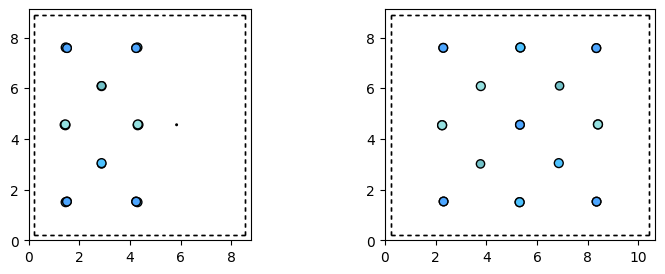

In [588]:
# Run relaxation, if needed
if RUN_RELAXATION:
    slab = import_vasp('input/HfNbTaZr_8.vasp', truncate=False)
    slab.center(vacuum=1)
    relax_output_filename = relax(slab)
    
# Create our slab
slab = output_to_atoms(relax_output_filename if RUN_RELAXATION else 'relax_data/relax_Hf5Nb2Ta10Zr5.out') # This slab is the result of relaxing a 22-atom crystal
atoms = deepcopy(slab)
atoms.center(vacuum=VACUUM, axis=2)
atoms = pin_bottom_layers(atoms, nlayers=1, axis=AXIS)

# Place the D atom in the center of the slab, `INITIAL_DISTANCE_A` Angstroms away
DEUTERIUM_XYZ = get_D_position(atoms, INITIAL_DISTANCE_A=INITIAL_DISTANCE_A, axis=AXIS, offset=OFFSET)
deuterium = Atom('H', mass=DEUTERIUM_MASS_AMU, position=DEUTERIUM_XYZ)
atoms.append(deuterium)

# Expand unit cell so that the D atom fits
existing_cell = atoms.get_cell()
atoms.set_cell(np.array([ # TODO this code is dogshit, clean it up
    existing_cell[0][0] + (2 * INITIAL_DISTANCE_A if AXIS == 'x' else 0),
    existing_cell[1][1] + (2 * INITIAL_DISTANCE_A if AXIS == 'y' else 0),
    existing_cell[2][2] + (2 * INITIAL_DISTANCE_A if AXIS == 'z' else 0)]
))

preview(atoms)

## Run MD

In [ ]:
output_filename = md(atoms, nsteps=N_STEPS, dt=DT, initial_eV=INITIAL_EV, suffix='fix_bottom_layer_only')

Writing D initial velocity 1000eV (0.14149136432947648 Hartree au)


In [ ]:
# We have to do this bit to get `ase` to be able to read the file in again
# TODO: file bugfix PR in ase
sanitize(output_filename)

From here, run `ase gui <output_filename>` to view the animation

![](preview.png)